In [1]:
import pandas as pd
import numpy as np
from keras import layers
from keras.layers import Input, Dense, Activation
from keras.models import Sequential
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
import keras.backend as K
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import itertools

Using TensorFlow backend.


In [2]:
dataset = pd.read_csv("creditcard.csv", header = 0)

In [3]:
model_features = dataset.iloc[:,1:30].columns

In [4]:
print(model_features)

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount'],
      dtype='object')


In [5]:
dataset["Amount"] = (dataset["Amount"] - dataset["Amount"].min()) / (dataset["Amount"].max() - dataset["Amount"].min())

In [6]:
dataset["Amount"].head(n=5)

0    0.005824
1    0.000105
2    0.014739
3    0.004807
4    0.002724
Name: Amount, dtype: float64

In [7]:
dataset = dataset.sample(frac=1).reset_index(drop=True)
split = np.random.rand(len(dataset)) < 0.85
dataset_train = dataset[split]
dataset_test = dataset[~split]

In [8]:
train_x = dataset_train.as_matrix(columns = model_features)
train_y = dataset_train["Class"]
test_x = dataset_test.as_matrix(columns = model_features)
test_y = dataset_test["Class"]

In [9]:
print(dataset["Amount"].sum())
print(train_y.mean()*100)
print(test_y.mean()*100)

979.4259975023715
0.1718383397772711
0.1779067862075423


In [10]:
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(242088, 29)
(242088,)
(42719, 29)
(42719,)


In [11]:
train_y = np.reshape(train_y, (len(dataset_train),1))
test_y = np.reshape(test_y, (len(dataset_test),1))

print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(242088, 29)
(242088, 1)
(42719, 29)
(42719, 1)


C:\Users\Samantha\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


In [12]:
class_weights = class_weight.compute_class_weight('balanced',
                                                np.unique(train_y),
                                                train_y.flatten())

In [13]:
def as_keras_metric(method):
    import functools
    @functools.wraps(method)
    def wrapper(self, args, **kwargs):
        """ Wrapper for turning tensorflow metrics into keras metrics """
        value, update_op = method(self, args, **kwargs)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([update_op]):
            value = tf.identity(value)
        return value
    return wrapper

precision = as_keras_metric(tf.metrics.precision)
recall = as_keras_metric(tf.metrics.recall)

In [14]:
model = Sequential()
model.add(Dense(14, activation="relu", input_shape=(29,)))
model.add(Dense(7, activation="relu"))
model.add(Dense(1, activation="sigmoid"))
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=[precision, recall, "accuracy"])

In [15]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 14)                420       
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 105       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 8         
Total params: 533
Trainable params: 533
Non-trainable params: 0
_________________________________________________________________


In [16]:
#class_weight=class_weights
model.fit(x=train_x, y=train_y, epochs = 10, class_weight = class_weights)

Epoch 1/10
242088/242088 [==============================] - 28s - loss: 0.0189 - precision: 0.0019 - recall: 0.9998 - acc: 0.9943    
Epoch 2/10
242088/242088 [==============================] - 21s - loss: 0.0031 - precision: 0.0017 - recall: 1.0000 - acc: 0.9994    
Epoch 3/10
242088/242088 [==============================] - 30s - loss: 0.0029 - precision: 0.0017 - recall: 1.0000 - acc: 0.9994    
Epoch 4/10
242088/242088 [==============================] - 26s - loss: 0.0027 - precision: 0.0017 - recall: 1.0000 - acc: 0.9994    
Epoch 5/10
242088/242088 [==============================] - 26s - loss: 0.0026 - precision: 0.0017 - recall: 1.0000 - acc: 0.9995    
Epoch 6/10
242088/242088 [==============================] - 23s - loss: 0.0025 - precision: 0.0017 - recall: 1.0000 - acc: 0.9995    
Epoch 7/10
242088/242088 [==============================] - 26s - loss: 0.0024 - precision: 0.0017 - recall: 1.0000 - acc: 0.9995    
Epoch 8/10
242088/242088 [==============================] - 25

In [17]:
score = model.evaluate(x = test_x, y = test_y)
print ("Loss = " + str(score[0]))
print ("Precision metric = " + str(score[1]))
print ("Recall metric = " + str(score[2]))
print ("Accuracy metric = " + str(score[3]))

41792/42719 [============================>.] - ETA: 0sLoss = 0.00196470177051
Precision metric = 0.00171955813775
Recall metric = 1.00000017958
Accuracy metric = 0.999648868164


In [18]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [19]:
y_pred = model.predict(x = test_x)

Confusion matrix, without normalization
[[42639     4]
 [   11    65]]


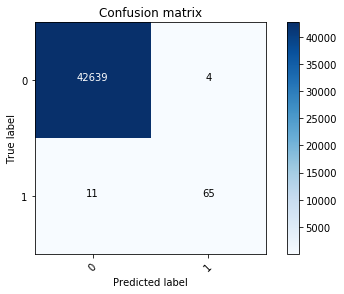

In [20]:
cnf_matrix = confusion_matrix(test_y, (y_pred>0.5).astype(int))
plot_confusion_matrix(cnf_matrix, classes = range(2))
plt.show()

In [21]:
test_frauds = pd.DataFrame({'Fraud':test_y[:,0]})

In [22]:
test_frauds.head()

,Fraud
0,0
1,0
2,0
3,0
4,0


In [23]:
idx = test_frauds.index[test_frauds['Fraud'] == 1]

In [24]:
test_x_frauds = test_x[idx]
test_y_frauds = test_y[idx]

In [25]:
score_frauds = model.evaluate(x = test_x_frauds, y = test_y_frauds)
print ("Loss = " + str(score[0]))
print ("Precision metric = " + str(score[1]))
print ("Recall metric = " + str(score[2]))
print ("Accuracy metric = " + str(score[3]))

32/76 [===========>..................] - ETA: 0sLoss = 0.00196470177051
Precision metric = 0.00171955813775
Recall metric = 1.00000017958
Accuracy metric = 0.999648868164


In [26]:
y_pred_frauds = model.predict(x = test_x_frauds)

Confusion matrix, without normalization
[[ 0  0]
 [11 65]]


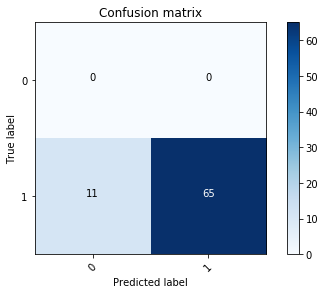

In [27]:
cnf_matrix = confusion_matrix(test_y_frauds, (y_pred_frauds>0.5).astype(int))
plot_confusion_matrix(cnf_matrix, classes = range(2))
plt.show()

In [28]:
idx2 = test_frauds.index[test_frauds['Fraud'] == 0]

In [29]:
test_x_notfrauds = test_x[idx2]
test_y_notfrauds = test_y[idx2]

In [30]:
score_frauds = model.evaluate(x = test_x_notfrauds, y = test_y_notfrauds)
print ("Loss = " + str(score[0]))
print ("Precision metric = " + str(score[1]))
print ("Recall metric = " + str(score[2]))
print ("Accuracy metric = " + str(score[3]))

41696/42643 [============================>.] - ETA: 0sLoss = 0.00196470177051
Precision metric = 0.00171955813775
Recall metric = 1.00000017958
Accuracy metric = 0.999648868164


In [31]:
preds = model.predict(x = test_x_notfrauds)

Confusion matrix, without normalization
[[42639     4]
 [    0     0]]


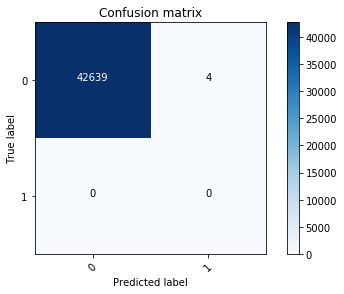

In [32]:
cnf_matrix = confusion_matrix(test_y_notfrauds, (preds>0.5).astype(int))
plot_confusion_matrix(cnf_matrix, classes = range(2))
plt.show()